In [53]:
import math

import snntorch as snn
from snntorch import spikegen
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List
from aes_commons import *
import random

In [54]:
config = {
    # Meta
    "no_epochs": 1,
    "batch_size" : 100_000,
    # SNN config
    "num_steps": 25,
    "beta": 0.95,
    
    # Network dimentions
    "num_inputs": 128,
    "num_spiking1": 128,
    "num_spiking2": 128,
    "num_hidden_out": 256,
    "num_outputs": 128
}

In [55]:


def bytes_to_float_array(data_block:List[uint8])->List[float]:
    result : List[float] = []
    
    for id, byte in enumerate(data_block):
        input = bin(byte)
        input = input[2:]
        input = input[::-1]
        for _ in range(8):
            result.append(0.0)

        for i, bit in enumerate(input):
            result[id * 8 + i] = float(bit)
            
    return result
print(bytes_to_float_array({uint8(6)}))

@dataclass
class CryptoDataset:

    no_bytes: int # no of bytes in ciphered message
    batch_size: int
    n :int
    
    @staticmethod
    def from_config():        
        return CryptoDataset(no_bytes=config["num_inputs"]//8,batch_size = config["batch_size"])
        
    def __init__(self,  no_bytes:int, batch_size:int):
        self.no_bytes = no_bytes
        self.batch_size = batch_size
        self.n = 0
    
    def next_sub_byte(self):
        
        label : List[uint8] = []
        for _ in range(self.no_bytes) :
            label.append(uint8(random.randint(0,255)))
        
        input : List[uint8] = mix_columns(label) 
        return (torch.FloatTensor(bytes_to_float_array(input)),torch.FloatTensor(bytes_to_float_array(label)))
    
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < self.batch_size:
            self.n += 1
            return self.next_sub_byte()
        else:
            raise StopIteration
    
    

[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [56]:

class SNNModel(nn.Module):
    def __init__(self):
        super().__init__();
        # Initialize layers
        self.fc0 = nn.Linear(config["num_inputs"], config["num_spiking1"])
        self.fc1 = nn.Linear(config["num_spiking1"], config["num_spiking2"])
        self.lif1 = snn.Leaky(beta=config["beta"])
        self.fc2 = nn.Linear(config["num_spiking2"], config["num_hidden_out"])
        self.lif2 = snn.Leaky(beta=config["beta"])
        
        self.fc3 = nn.Linear(config["num_hidden_out"], config["num_hidden_out"])
        self.drop = nn.Dropout(p=0.1, inplace=False)
        self.fc4 = nn.Linear(config["num_hidden_out"], config["num_outputs"])

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state for each pass
        memory1 = self.lif1.init_leaky()
        memory2 = self.lif2.init_leaky()
        
        result_spikes = []
        result_membrain = []
        y = self.fc0(x)
        
        x = spikegen.rate(x, num_steps=config["num_steps"])
        
        spike_sum = torch.zeros(config["num_hidden_out"])
        for step in range(config["num_steps"]):
            cur1 = self.fc1(y)
            spikes1, memory1 = self.lif1(cur1, memory1)
            cur2 = self.fc2(spikes1)
            spikes2, memory2 = self.lif2(cur2, memory2)
            spike_sum += spikes2
        
        # spike_sum = self.sigmoid(spike_sum)
        out = self.fc3(spike_sum)
        out = self.relu(out)
        out = self.drop(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        
        # Maybe another dense layer
        
        return self.sigmoid(out)


In [57]:
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(config['num_inputs'], config['num_hidden_out'])
        self.fc2 = nn.Linear(config['num_hidden_out'], config['num_hidden_out'])
        self.dropout = torch.nn.Dropout(p=0.1, inplace=False)
        self.fc3 = nn.Linear(config['num_hidden_out'], config['num_outputs'])

    def forward(self, x):
        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(F.relu(x)))
        return x



In [58]:
spiking = SNNModel()
standard = NNModel()
spiking, standard

(SNNModel(
   (fc0): Linear(in_features=128, out_features=128, bias=True)
   (fc1): Linear(in_features=128, out_features=128, bias=True)
   (lif1): Leaky()
   (fc2): Linear(in_features=128, out_features=256, bias=True)
   (lif2): Leaky()
   (fc3): Linear(in_features=256, out_features=256, bias=True)
   (drop): Dropout(p=0.1, inplace=False)
   (fc4): Linear(in_features=256, out_features=128, bias=True)
   (sigmoid): Sigmoid()
   (relu): ReLU()
 ),
 NNModel(
   (fc1): Linear(in_features=128, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=256, bias=True)
   (dropout): Dropout(p=0.1, inplace=False)
   (fc3): Linear(in_features=256, out_features=128, bias=True)
 ))

In [59]:
from torch.utils.data import DataLoader
train_loader = CryptoDataset.from_config()
train_loader

CryptoDataset(no_bytes=16, batch_size=100000, n=0)

In [60]:
import snntorch.spikeplot as splt

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data =spikegen.rate(data_it, num_steps=config["num_steps"])
spike_data.size()

torch.Size([25, 128])

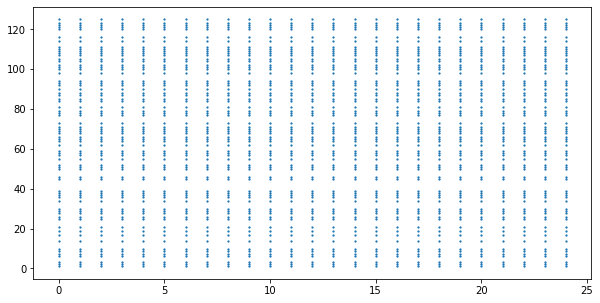

In [61]:
spike_data = spike_data[:]
spike_data_sample_plot = spike_data.reshape((config["num_steps"], -1))
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample_plot, ax, s=1.5)

In [62]:
loss_func = nn.L1Loss() # Idk
snn_optimizer = torch.optim.Adam(spiking.parameters(), lr=0.0005)
nn_optimizer = torch.optim.Adam(standard.parameters(), lr=0.0005)
nn_loss_hist = []
snn_loss_hist = []

In [63]:
from tqdm import tqdm
for epoch in range(config["no_epochs"]):
    for batch_idx, (x, y) in tqdm(enumerate(train_loader), total=config["batch_size"], desc=f"Epoch {epoch}"):
        spiking.train()
        standard.train()
        
        y = x

        # forward
        output = spiking(x)
        snn_loss = loss_func(output, y)
        
        # Gradient calculation + weight update
        snn_optimizer.zero_grad()
        snn_loss.backward()
        snn_optimizer.step()
        
        # forward
        output = standard(x)
        nn_loss = loss_func(output, y)
        # Gradient calculation + weight update
        nn_optimizer.zero_grad()
        nn_loss.backward()
        nn_optimizer.step()

        # Store loss history for future plotting
        snn_loss_hist.append(snn_loss.item())
        nn_loss_hist.append(nn_loss.item())

Epoch 0: 100%|██████████| 100000/100000 [11:17<00:00, 147.68it/s]


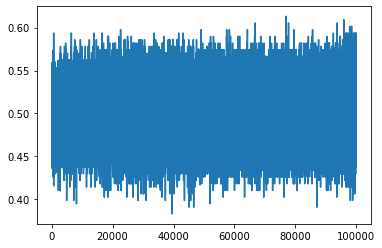

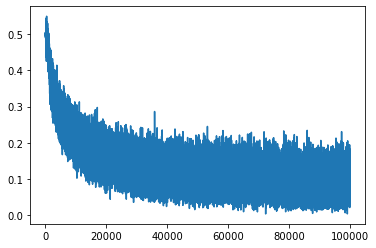

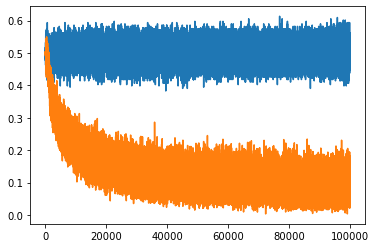

In [64]:
# plt.yscale("log")
plt.plot(snn_loss_hist)
plt.show()
plt.plot(nn_loss_hist)
plt.show()
plt.plot(snn_loss_hist)
plt.plot(nn_loss_hist)

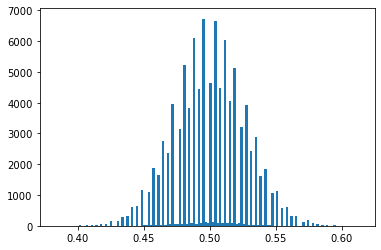

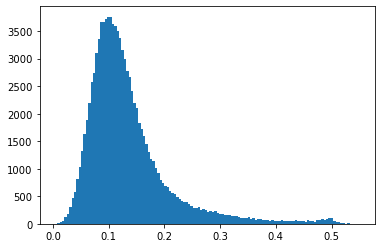

(array([5.000e+00, 9.000e+00, 3.200e+01, 5.000e+01, 1.220e+02, 1.780e+02,
        3.050e+02, 4.730e+02, 5.720e+02, 8.050e+02, 1.034e+03, 1.326e+03,
        1.633e+03, 1.877e+03, 2.186e+03, 2.574e+03, 2.745e+03, 3.094e+03,
        3.349e+03, 3.660e+03, 3.674e+03, 3.716e+03, 3.762e+03, 3.758e+03,
        3.634e+03, 3.600e+03, 3.507e+03, 3.383e+03, 3.165e+03, 2.993e+03,
        2.774e+03, 2.670e+03, 2.417e+03, 2.198e+03, 2.103e+03, 1.829e+03,
        1.725e+03, 1.603e+03, 1.453e+03, 1.299e+03, 1.180e+03, 1.138e+03,
        1.011e+03, 9.280e+02, 8.020e+02, 7.460e+02, 6.870e+02, 6.700e+02,
        6.010e+02, 5.520e+02, 5.420e+02, 4.870e+02, 4.570e+02, 4.140e+02,
        4.020e+02, 3.870e+02, 3.560e+02, 3.240e+02, 2.810e+02, 2.910e+02,
        3.030e+02, 2.500e+02, 2.630e+02, 2.510e+02, 2.210e+02, 2.290e+02,
        2.090e+02, 2.340e+02, 1.920e+02, 1.700e+02, 1.860e+02, 1.580e+02,
        1.680e+02, 1.540e+02, 1.360e+02, 1.370e+02, 1.340e+02, 1.290e+02,
        1.100e+02, 1.050e+02, 1.120e+0

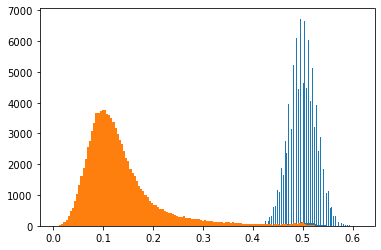

In [65]:
plt.hist(snn_loss_hist,bins=128)
plt.show()
plt.hist(nn_loss_hist,bins=128)
plt.show()
plt.hist(snn_loss_hist,bins=128)
plt.hist(nn_loss_hist,bins=128)

In [66]:
import numpy as np

def count_bad(input: torch.Tensor, output: torch.Tensor):
    assert len(input) == len(output)

    input = input.detach().numpy()
    output = output.detach().numpy()
    input, output = np.around(input, 0) , np.around(output, 0)
    diff = np.abs(input - output)
    return sum(diff)


a = torch.tensor([0.23, .33, .66])
b = torch.tensor([0.33, .46, .70])
c = torch.tensor([.55, .12, .1])
assert count_bad(a,b) == 0
assert count_bad(a,c) == 2

In [67]:
spiking_global_loss = .0
standard_global_loss = .0
samples = 1000
spiking.eval()
standard.eval()
with torch.no_grad():
    for index in range(samples):
        inputs, labels = train_loader.next_sub_byte()
        outputs = spiking(inputs)
        spiking_global_loss += count_bad(inputs, outputs) / config["num_outputs"]
        
        outputs = standard(inputs)
        standard_global_loss += count_bad(inputs, outputs) / config["num_outputs"]

print("Spiking incorrect: ", config["num_outputs"] * spiking_global_loss / samples)
print("Standard incorrext: ", config["num_outputs"] * standard_global_loss / samples)

Spiking incorrect:  63.803
Standard incorrext:  3.321


In [68]:
import math

def binomial(k, n, p=0.5):
    """Binomial distribution with 

    Args:
        k (int): Number of successes
        n (int): Number of trials
        p (float, optional Probability of success. Defaults to 0.5.

    Returns:
        (float): Probability of exactly k successes
    """
    return (math.comb(n,k) * (p**k) * ((1-p)**(n-k)))

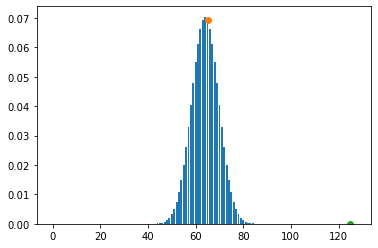

In [69]:
plt.bar(list(range(config["num_outputs"])), [binomial(i, config["num_outputs"]) for i in range(config["num_outputs"])])

spiking_ok = config["num_outputs"] - int(config["num_outputs"] * spiking_global_loss / samples)
plt.scatter([spiking_ok],binomial(int(spiking_ok), config["num_outputs"]))

standard_ok = config["num_outputs"] - int(config["num_outputs"] * standard_global_loss / samples)
plt.scatter([standard_ok],binomial(int(standard_ok), config["num_outputs"]))